In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from scipy import stats
from scipy.stats import norminvgauss, norm, pareto, levy_stable

import random

import torchvision

import tqdm
from tqdm import trange

import pandas as pd
import csv


from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)


class Monitor:
    def __init__(self):
        if hasattr(tqdm.tqdm, '_instances'):
            [*map(tqdm.tqdm._decr_instances, list(tqdm.tqdm._instances))]

        self.learning_curve = []
        self.train_accuracy_curve = []
        self.val_accuracy_curve = []
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

    def add_loss_value(self, value):
        self.learning_curve.append(value)

    def add_train_accuracy_value(self, value):
        self.train_accuracy_curve.append(value)

    def add_val_accuracy_value(self, value):
        self.val_accuracy_curve.append(value)

        if value > self.best_val_accuracy:
            self.best_val_accuracy = value
            self.best_val_epoch = len(self.val_accuracy_curve)

    def show(self):
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))
        axes[0].set_title('Loss')
        axes[0].plot(self.learning_curve)

        last_train_accuracy = self.train_accuracy_curve[-1]
        last_val_accuracy = self.val_accuracy_curve[-1]
        best_val_accuracy = self.best_val_accuracy
        best_val_accuracy = self.best_val_accuracy

        axes[1].set_title(f'Train {last_train_accuracy:.4f}, val {last_val_accuracy:.4f}, '
                          f'max val {self.best_val_accuracy:.4f} at {self.best_val_epoch}')
        axes[1].plot(self.train_accuracy_curve)
        axes[1].plot(self.val_accuracy_curve)

        plt.tight_layout()
        plt.show()


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


## 1 Fully-connected network (FCN) on the CIFAR10 
For this model, we vary the width and batch size. 

In [ ]:
class FullyConnected(nn.Module):

    def __init__(self, input_dim=28*28, width=16, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.num_classes = num_classes

        layers = self.get_layers()

        self.fcn = nn.Sequential(
            # nn.Linear(self.input_dim, self.width, bias=False),
            nn.Linear(3072, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):

        layers = []
        for _ in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        r"""
        Parameters
        ----------
        x : torch.Tensor
            of shape [batch_size, channels_n, height, width]
        
        Returns
        -------
        y : torch.Tensor
            of shape [batch_size, classes_n]
        """
        # x = x.view(x.size(0), self.input_dim)
        x = x.view(batch_size, 3072)
        x = self.fcn(x)
        return x

## 2 Training procedure

In [ ]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Method for gathering gradients from NN
def get_grads(model):
    grads = []
    for param in model.parameters():
        if param.requires_grad == True:
            grads.append(param.grad.view(-1))
    grad_flat = torch.cat(grads)
    return grad_flat

def save_grads(model, optimizer, loss_function, train_loader, device, filepath, log_num_iter):
    with open(filepath + f'_epoch_logiter_{log_num_iter}.npy', 'ab') as file:

        for model_input_gr, target_gr in train_loader:
            model_input_gr = model_input_gr.to(device)
            target_gr = target_gr.to(device)
            model_output_gr = model(model_input_gr)
            loss_gr= loss_function(model_output_gr, target_gr)
            optimizer.zero_grad()
            #calc the gradient on batch
              # ? do we need retain_grads=False
            loss_gr.backward()
              #store the gradient
              #Full gradient will be calculated later, 
              #as mean of the saved gradients of all batches 
            grad = get_grads(model).cpu()
            np.save(file, grad.numpy())


def train(model, optimizer, loss_function, train_loader, val_loader, device, filepath, epochs=1, plot_each=1, log_iter=100):
    # send the model to that device
    model = model.to(device)
    monitor = Monitor()
    
    log_num_iter=0
    for epoch in trange(epochs):
        model.train()
        
        for iter, (model_input, target)  in enumerate(train_loader):
            
            #Idea1 no batches full data-> bad runtime out of memory
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            # do some visualization
            monitor.add_loss_value(loss.item())
            #calculate grad on iteration
            if (iter+1) % log_iter == 0:
                log_num_iter+=1
                with open(filepath + f'_logiter_{log_num_iter}.npy', 'ab') as file:
                    for model_input_gr, target_gr in train_loader:
                        model_input_gr = model_input_gr.to(device)
                        target_gr = target_gr.to(device)
                        model_output_gr = model(model_input_gr)
                        loss_gr= loss_function(model_output_gr, target_gr)
                        optimizer.zero_grad()
                        #calc the gradient on batch
                        # ? do we need retain_grads=False
                        loss_gr.backward()
                                #store the gradient
                                #Full gradient will be calculated later, 
                                #as mean of the saved gradients of all batches 
                        grad = get_grads(model).cpu()
                        np.save(file, grad.numpy())
        # evaluate the model
        model.eval()
            
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()

    return model

## 3 Experiment


In [ ]:
# # NN parameters
# seeds = list(range(3))


# depth = [2, 3, 4, 5]
# width = [1632, 64, 128, 256, 512, 1024]
# batch_size = [50, 100, 150, 200, 300]

# Hyperparameters
width = 128
depth = 2
batch_size = 50
lr = 1e-2
epochs = 10
log_iter=100
# total_iterations=int(epochs*(50000/batch_size)/log_iter)
# print('total iterations',total_iterations)

filepath = '/content/gdrive/MyDrive/Gradient_exp_cifar10/grads_batch_100v2'





In [ ]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

from torchvision.datasets import CIFAR10

mnist_train = CIFAR10(root = './', train=True, download=True, 
                    transform=torchvision.transforms.ToTensor())
mnist_val = CIFAR10(root = './', train=False, download=True, 
                  transform=torchvision.transforms.ToTensor())


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


### Mini-Batch Stochastic Gradient Descent


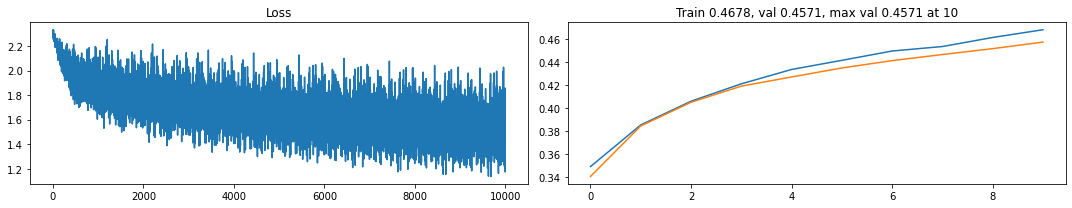

100%|██████████| 10/10 [01:47<00:00, 10.76s/it]


In [ ]:
set_random_seeds(device=device)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)# num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size)#, num_workers=2)

model = FullyConnected(input_dim=32*32, width=width, depth=depth, num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

mini_batch_100_model = train(model, optimizer, loss_function,
                             train_loader, val_loader,
                             device, filepath=filepath, epochs=epochs,
                             log_iter=100)

## 4 SG noise distribution's exploration

### 4.1 Calculating SGN and launching $\alpha$-estimator

 

In [ ]:
def alpha_estimator(x):

    K = len(x)
    list1 = np.array([d for d in range (1, K // 2 + 1) if K % d == 0] + [K])
    difference = abs(np.sqrt(K) - list1)
    K_1 = list1[np.argmin(difference)]
    K_2 = int(K/K_1)
    y = np.zeros(K_2)
    for i in range(K_2):
        y[i] = sum((x[j + (i-1) * K_1] for j in range(K_1)))

    return 1 / ((1/np.log(K_1)) * ((1/K_2) * sum(np.log(abs(y))) - (1/len(x)) * sum(np.log(abs(x)))))

def alpha_dynamics(mean_alphas, params):
    plt.figure(figsize=(12, 8))
    plt.plot(params, mean_alphas, 'o-', label=r'$ \alpha $')
    plt.xlabel('Epochs', size=13)
    plt.ylabel(r'mean $ \alpha $', size=13)
    plt.title(r'$ \alpha $ dynamics', size=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig(filepath + '_ep_50_alpha_dynamics.png')
    plt.show()


In [ ]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches
# N = 1000
N = 50000 // batch_size
alphas = []
sgn_storage = []



for iteration in range(1, 11, 1):
    batch_grads = []
    with open(filepath + f'_logiter_{iteration}.npy', 'rb') as file:
      # print(file)  
      for _ in range(100):
        # print(i)
        # np.load(file)
        batch_grads.append(np.load(file))

    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
#     sgn_storage.append(sgn)
#     del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn))
    sgn_storage.append(sgn[[i for i in range(0, 22001, 1400)]])
    del(sgn)
#     sgn_storage[-1] = sgn_storage[-1][[111, 5586, 11254, 15869, 22000,]]
    print(sgn_storage[-1].shape)
    

mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

del(alphas)
with open(filepath + 'mean_alphas.npy', 'wb') as file:
    np.save(file, np.array(mean_alphas))

sgn_storage = np.array(sgn_storage)
# sgn_storage.shape
with open(filepath + 'sgn_5_samples.npy', 'wb') as file:
    np.save(file, sgn_storage)

# alpha_dynamics(mean_alphas, [100 * i for i in range(1, int(total_iterations + 1))])
 

(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)
(16, 100)


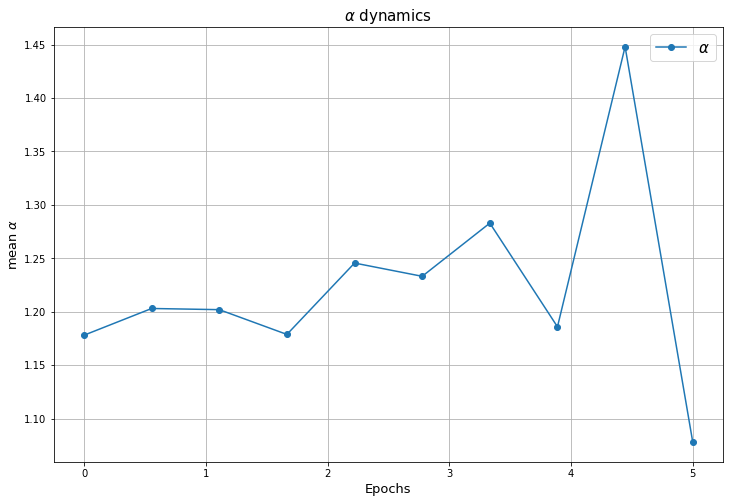

In [ ]:
alpha_dynamics(mean_alphas, np.linspace(0, 5, 10))   

### 4.2 Visualizing SGN distribution

In [ ]:
def SGD_noise_distplots(SGD_noise, distribution, dist_name, bins):

  params = distribution.fit(SGD_noise)
  Theoretical_dist = distribution(*params)
  x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

  SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

  fig, axs = plt.subplots(4, 1, figsize=(16, 40))
  # axs[0].hist(SGD_noise, density=True, bins=bins, color='white', ec='black', label='SGD Noise')
  axs[0].hist(SGD_noise, density=True, bins=bins, label='SGD Noise')
  axs[0].hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label=dist_name)
  # axs[0].plot(x, Theoretical_dist.pdf(x), '--', color='black', label='Gaussian')
  axs[0].set_xlabel('SGD noise', size=13)
  axs[0].set_ylabel('Density', size=13)
  axs[0].set_title('SGD noise hist', size=15)
  axs[0].legend(fontsize=15)

  axs[1].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[1].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[1].set_xlabel('SGD noise', size=13)
  axs[1].set_ylabel('Density', size=13)
  axs[1].set_title('SGD noise dotted hist', size=15)
  axs[1].legend(fontsize=15)

  axs[2].set_yscale('log')
  axs[2].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[2].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[2].set_xlabel('SGD noise', size=13)
  axs[2].set_ylabel('log-scaled Density', size=13)
  axs[2].set_title('SGD noise dotted log hist', size=15)
  axs[2].legend(fontsize=15)

  stats.probplot(SGD_noise, dist=Theoretical_dist, plot=plt)
  plt.title('SGD noise QQ-plot', size=15)
  plt.xlabel('Theoretical Quantiles', size=13)
  plt.ylabel('Sample Quantiles', size=13)

  plt.grid()
  

  plt.show()  

## Epoch #5

In [ ]:
# 1200 gradients per batch for 89911 neurons in 5th epoch
sgn_storage[0].shape

(16, 100)

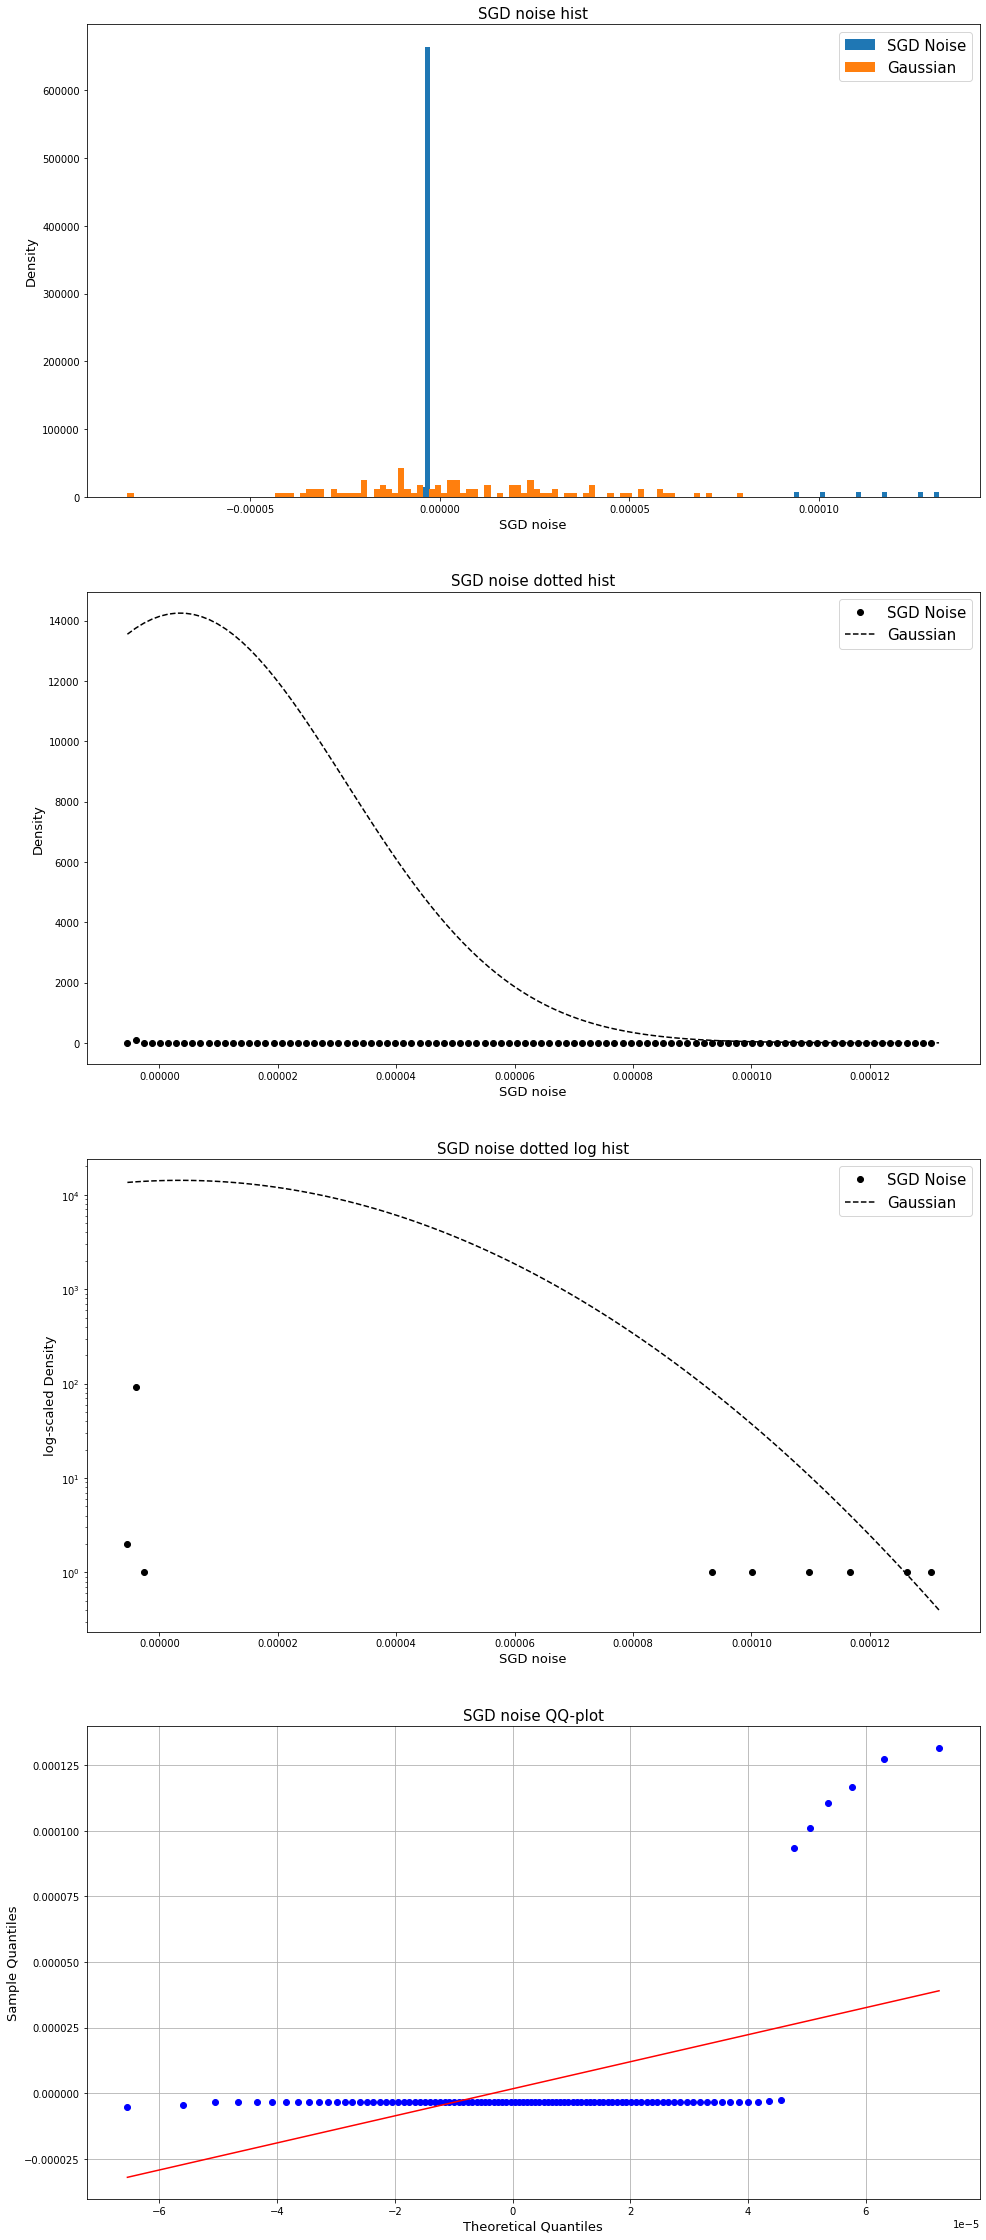

In [ ]:
SGD_noise_distplots(SGD_noise=sgn_storage[5][-1], distribution=norm, dist_name='Gaussian', bins=100)

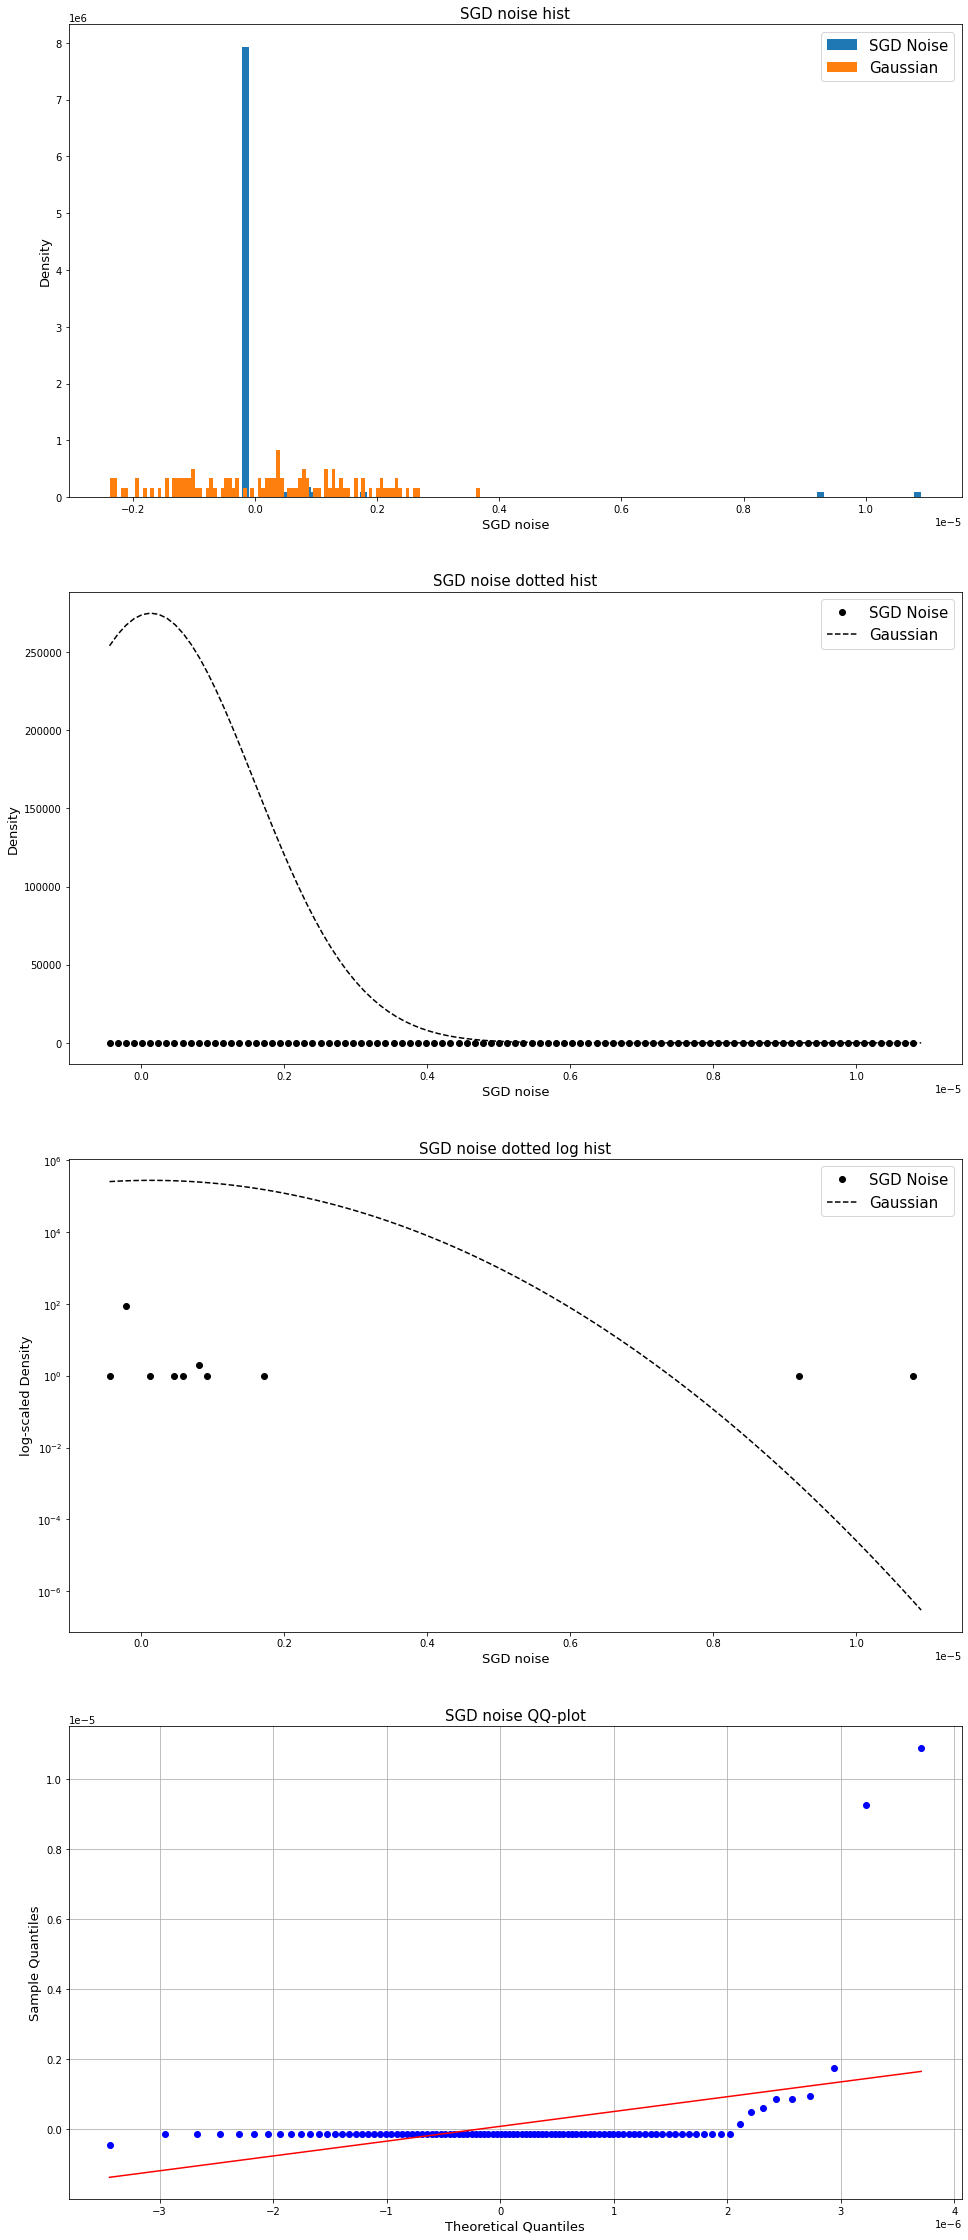

In [ ]:
SGD_noise_distplots(SGD_noise=sgn_storage[5][-2], distribution=norm, dist_name='Gaussian', bins=100)

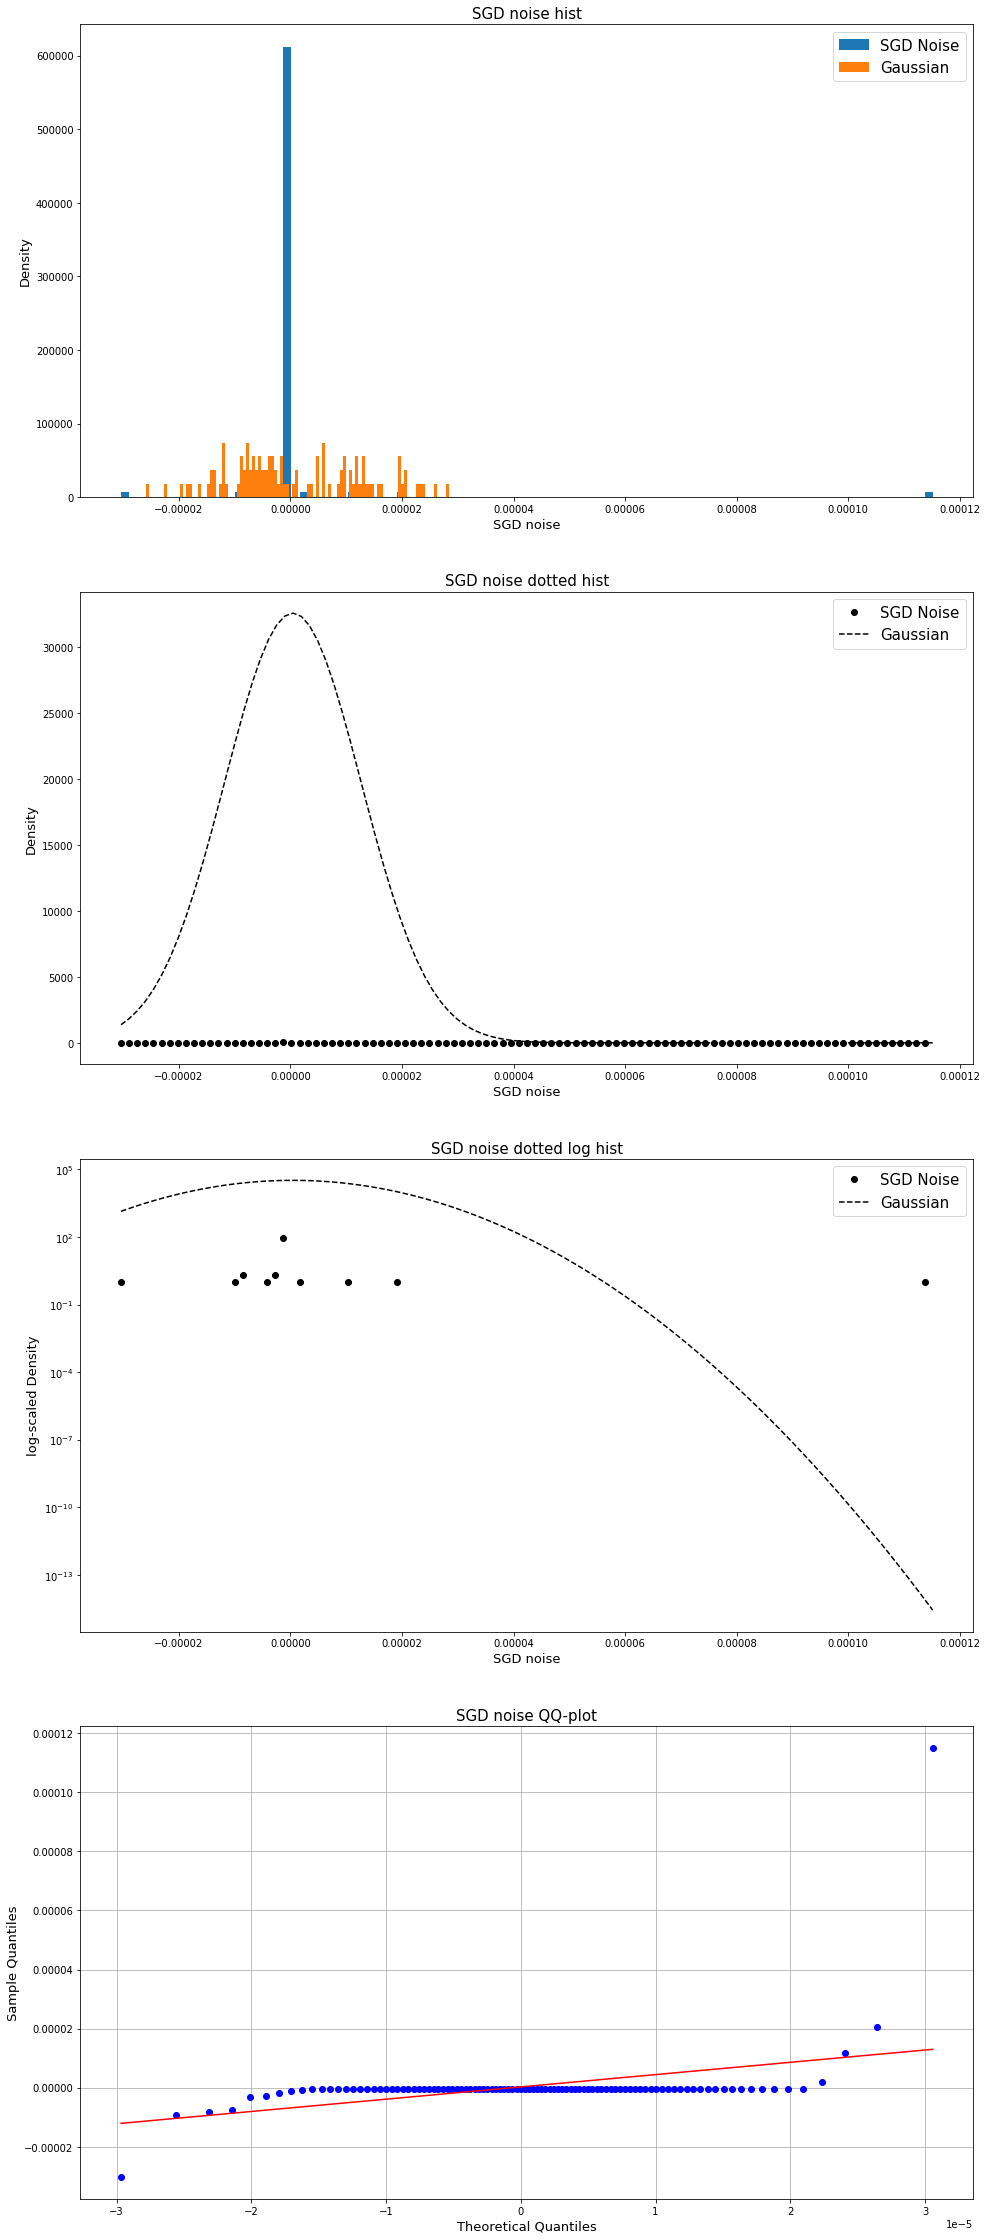

In [ ]:
SGD_noise_distplots(SGD_noise=sgn_storage[5][-3], distribution=norm, dist_name='Gaussian', bins=100)

In [ ]:
# SGD_noise_distplots(SGD_noise=sgn_storage[0][839], distribution=norm, dist_name='Gaussian', bins=100)

## Epoch #10

In [ ]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
# sgn_storage[1].shape

In [ ]:
# SGD_noise_distplots(SGD_noise=sgn_storage[1][111], distribution=norm, dist_name='Gaussian', bins=100)

In [ ]:
# SGD_noise_distplots(SGD_noise=sgn_storage[1][-1], distribution=norm, dist_name='Gaussian', bins=100)

In [ ]:
# SGD_noise_distplots(SGD_noise=sgn_storage[1][586], distribution=norm, dist_name='Gaussian', bins=100)

In [ ]:
# SGD_noise_distplots(SGD_noise=sgn_storage[1][839], distribution=norm, dist_name='Gaussian', bins=100)